# Часть 1. Проверка гипотезы в Python и составление аналитической записки

- Автор: Сумароков Сергей
- Дата: 04.05.2025

## Цели и задачи проекта

Цель проекта - проверить гипотезу о том, что пользователи из Санкт-Петербурга проводят в среднем больше времени за чтением и прослушиванием книг в приложении, чем пользователи из Москвы, на основе данных об их активности.

Задачи проекта:
- Загрузить и подготовить данные
- Провести исследовательский анализ данных
- Проверить гипотезы
- Интерпретировать полученные результаты
- Подготовить аналитическую записку 

## Описание данных

Для работы представлена таблица `yandex_knigi_data.csv`, которая содержит в себе поля:

- `Unnamed: 0` - индекс, оставшийся после выгрузки данных;
- `city` - город, в котором проживает пользователь;
- `puid` - уникальный id пользователя;
- `hours` - сумма часов активности пользователей.

## Содержимое проекта

1. Загрузка данных и знакомство с ними
2. Проверка гипотезы в Python
3. Аналитическая записка

In [1]:
# Импортируем необходимые библиотеки для выполнения проекта
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from statsmodels.stats.proportion import proportions_ztest

## 1. Загрузка данных и знакомство с ними

### Загрузка данных

In [ ]:
# Загрузим данные из датасета
df = pd.read_csv('datasets/yandex_knigi_data.csv')

In [3]:
# Выведем основную информацию о датафрейме
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  8784 non-null   int64  
 1   city        8784 non-null   object 
 2   puid        8784 non-null   int64  
 3   hours       8784 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 274.6+ KB


Тип данных в колонах соотвествует из содержимому, пропусков не обнаружено.

In [4]:
# Познакомимся с данными
display(df)

,Unnamed: 0,city,puid,hours
0,0,Москва,9668,26.167776
1,1,Москва,16598,82.111217
2,2,Москва,80401,4.656906
3,3,Москва,140205,1.840556
4,4,Москва,248755,151.326434
...,...,...,...,...
8779,8779,Санкт-Петербург,1130000028554332,4.107774
8780,8780,Санкт-Петербург,1130000030307246,45.069222
8781,8781,Санкт-Петербург,1130000038726322,0.211944
8782,8782,Санкт-Петербург,1130000047892100,4.311841


В датафрейме повторяюся столбцы с индексом, для удобства уберем столбец `Unnamed: 0` из датафрейма.

In [5]:
df = df[['city', 'puid', 'hours']]

### Проверка данных на дубликаты

Для начала найдем количество явных дубликатов в датафрейме:

In [6]:
dup = df.duplicated().sum()
print(f'Количество явных дубликатов: {dup}')

Количество явных дубликатов: 0


Теперь проверим наличие дубликатов по полю `puid`:

In [7]:
dup_puid = df.duplicated(subset=['puid']).sum()
share = round(dup_puid / df['puid'].count(),2) * 100 
print(f'В поле puid найдено дубликатов: {dup_puid} ({share}% от всех данных).')

В поле puid найдено дубликатов: 244 (3.0% от всех данных).


В поле `puid` оказалось 244 дубликата. Возможно, они появилисьиз-за нахождения одних и тех же пользователей в разных городах. Т.к количество дубликатов всего 3% от общего числа, можно удалить дубликаты чтобы сохранить независимость выборок для A/B теста.

In [8]:
# Используем метод drop_duplicates для удаления дубликатов
df.drop_duplicates(subset=['puid'], keep=False, inplace=True)

### Проверка данных на выбросы

Выведем описательную статистику столбца `hours`:

In [9]:
# Используем метод describe для столбца hours
df['hours'].describe()

count    8296.000000
mean       10.963892
std        37.753906
min         0.000022
25%         0.057493
50%         0.884214
75%         5.944675
max       978.764775
Name: hours, dtype: float64

В столбце `hours`:
- всего 8296 строк
- минимальное значение - 0.000022
- среднее значение - 10.96
- медиана - 0.88
- стандартное отклонение - 37.75
- максимальное значение - 978.76

В датафрейме нашелся человек, у которого суммарное количество прослушиваний составило 978 часов или почти 41 сутки беспрерывного прослушивания. Вполне вероятно, что это выброс в данных, который влияет на среднее значение - из-за этого оно сильно отличается от медианы.

Чтобы избавиться от этого и ближайших к нему выбросов и сделать распределение данных более равномерным, используем фильтрацию по 95-му процентилю:

In [10]:
# Фильтруем даннные по 95-му процентилю
filter95 = df['hours'].quantile(0.95)
df = df[df['hours'] <= filter95]

# Снова выводим описательную статистику
df['hours'].describe()

count    7881.000000
mean        4.733189
std         9.285352
min         0.000022
25%         0.047964
50%         0.710734
75%         4.383130
max        55.577836
Name: hours, dtype: float64

После фильтрации из датафрейма удалилось около 500 строк и данные приобрели более равномерный вид. Значимые изменения в столбце `hours`:
- среднее значение - 4.73 (было 10.96)
- стандартное отклонение - 9.28 (было 37.75)
- максимальное значение - 55.57 (было 978.76)

### Распеределение данных между группами

Теперь выделим две выборки из датафрейма `msc` для пользователей из Москвы и `spb` для пользователей из Санкт-Петербурга.

In [11]:
# Выделяем выборки 
msc = df[df['city'] == 'Москва']['hours']
spb = df[df['city'] == 'Санкт-Петербург']['hours']

Сравним средние значения часов прослушивания между выборками:

In [12]:
print('Среднее значение активности пользователей в Москве', round(msc.mean(),2))
print('Среднее значение активности пользователей в Санкт-Петербурге', round(spb.mean(),2))

Среднее значение активности пользователей в Москве 4.64
Среднее значение активности пользователей в Санкт-Петербурге 4.97


После проверки датафрейма на выбросы среднее значение активности в Москве все еще меньше, чем в Санкт-Петербурге, однако, нельзя утверждать, что пользователи из Санкт-Петербурга действительно более активны.

Построим гистограмму и диаграмму размаха по столбцу `hours`, чтобы визуально оценить распределение между выборками:

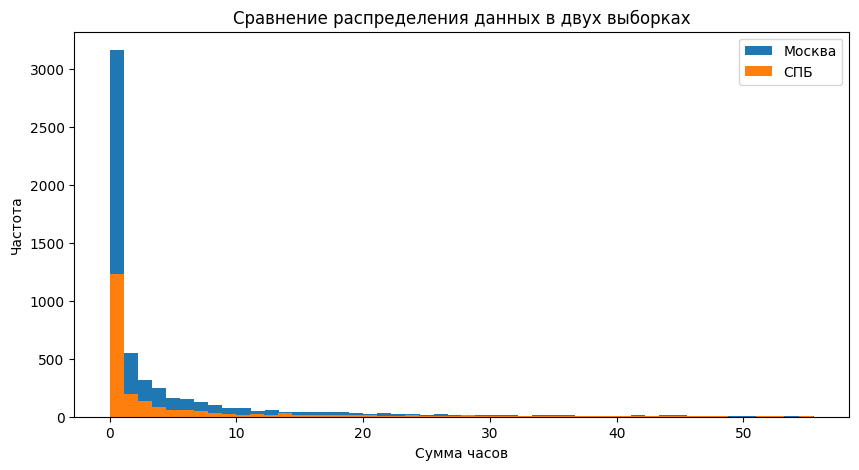

In [13]:
# Строим гистрограмму
plt.figure(figsize=(10,5))

plt.hist(msc, bins=50, label='Москва')
plt.hist(spb, bins=50, label='СПБ')

plt.title('Сравнение распределения данных в двух выборках')
plt.xlabel('Сумма часов')
plt.ylabel('Частота')

plt.legend()
plt.show()

Графики показывают сильное смещение значений вправо, что говорит о ненормальном распределении данных в столбце `hours`. При этом характер распределения у двух выборок одинаковый.

Проверим, как распределены данные датафрейма между двумя группами пользователей: жителями Москвы и Санкт-Петербурга.

In [14]:
users_city = df.groupby('city')['puid'].count()
print(users_city)

city
Москва             5692
Санкт-Петербург    2189
Name: puid, dtype: int64


Пользователи поделены между группами неравномерно, количество жителей Москвы намного больше, чем жителей Санкт-Петербурга.

## 2. Проверка гипотезы в Python

Гипотеза звучит так: пользователи из Санкт-Петербурга проводят в среднем больше времени за чтением и прослушиванием книг в приложении, чем пользователи из Москвы.

- Нулевая гипотеза H₀: Средняя активность пользователей в часах в двух группах (Москва и Санкт-Петербург) не различается.

- Альтернативная гипотеза H₁: Средняя активность пользователей в Санкт-Петербурге больше, и это различие статистически значимо.

Чтобы сравнить группы пользователей, воспользуемся непараметрическим **тестом Манна-Уитни**, который устойчив к выбросам в данных и не требует одинакого размера выборок. С помощью этого теста мы проверим, является ли распределение между выборками одинаковым, несмотря на разницу в количестве пользователей. Если предположение подтвердится, то перейдем к **t-тесту**.

Для всех тестов укажем уровень значимости альфа = 0.05. 

Параметр alternative указываем 'two-sided', т.к предполагается, что распределение метрик может отличаться в обе стороны между группами. 

In [15]:
# Задаем уровень значимости
alpha = 0.05

# Произведем тест Манна-Уитни
mw_test = mannwhitneyu(
    msc,
    spb,
    alternative='two-sided'
)

if mw_test.pvalue > alpha:
    print('Распределение метрики в группах msc и spb равны.')
else:
    print('Распределение метрики в группах msc и spb различаются')

Распределение метрики в группах msc и spb равны.


Можно утверждать, что распределение метрик между группами не различается, поэтому можно перейти к Т-тесту. Т.к распределение данных не является нормальным, нельзя говорить о равенстве дисперсий в группах, поэтому воспользуемся Т-тестом Уэлча, которому не нужно равенство дисперсий двух выборок.

In [16]:
# Произведем Т-тест Уэлча
stat_welsh_ttest, pvalue = ttest_ind(
    msc,
    spb,
    equal_var=False, # Параметр неравенства дисперсий
    alternative='less'
)

print('Значение pvalue:', round(pvalue,2))

if pvalue > alpha:
    print('Средняя активность пользователей в часах в двух группах (Москва и Санкт-Петербург) не различается.')
else:
    print('Средняя активность пользователей в Санкт-Петербурге больше, и это различие статистически значимо.')

Значение pvalue: 0.09
Средняя активность пользователей в часах в двух группах (Москва и Санкт-Петербург) не различается.


## 3. Аналитическая записка

Для сравнения двух выборок был выбран t-тест Уэлча, уровень статистической значимости alpha = 0.05. Был выбран именно этот тест, т.к нельзя утверждать, что дисперсии между двумя группами равны, t-тест Уэлча не чувствителен к этому. 

Результат теста - Нулевая гипотеза находит подтверждение, значение pvalue = 0.09.

Т.к значение pvalue = 0.09 > alpha = 0.05, можно утверждать, что средняя активность пользователей в часах в двух группах (Москва и Санкт-Петербург) не различается.

Возможные причины полученного результата:
- Выборка пользователей из Санкт-Петербурга оказалась сильно меньше выборки пользователей из Москвы, что могло исказить результаты.
- Т.к выборка пользователей из Моксвы сильно больше, при расчете среднего значения часов прослушиваний для Москвы оно оказалось меньше, чем в Санкт-Петербурге. Из-за этого могло показаться, что пользователи в Санкт-Петербурге пользуются сервисом более активно, чем в Москве.

----

# Часть 2. Анализ результатов A/B-тестирования

## 1. Цели исследования



Основная цель - оценить конверсию пользователей тестовой группы из посетителей интернет-магазина в покупателей на основе данных их активности.

Задачи:
- загрузить данные и оценить их целостность
- оценить корректность проведения теста
- провести оценку результатов теста

## 2. Загрузка данных, оценка их целостности.


In [17]:
participants = pd.read_csv('https://code.s3.yandex.net/datasets/ab_test_participants.csv')
events = pd.read_csv('https://code.s3.yandex.net/datasets/ab_test_events.zip',
                     parse_dates=['event_dt'], low_memory=False)

Выведем основную информацию о датафреймах `participants` и `events`:

In [18]:
participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
 3   device   14525 non-null  object
dtypes: object(4)
memory usage: 454.0+ KB


In [19]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 787286 entries, 0 to 787285
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     787286 non-null  object        
 1   event_dt    787286 non-null  datetime64[ns]
 2   event_name  787286 non-null  object        
 3   details     249022 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 24.0+ MB


Теперь посмотрим на структуру датафреймов:

In [20]:
display(participants)

,user_id,group,ab_test,device
0,0002CE61FF2C4011,B,interface_eu_test,Mac
1,001064FEAAB631A1,B,recommender_system_test,Android
2,001064FEAAB631A1,A,interface_eu_test,Android
3,0010A1C096941592,A,recommender_system_test,Android
4,001E72F50D1C48FA,A,interface_eu_test,Mac
...,...,...,...,...
14520,FFE7FC140521F5F6,A,interface_eu_test,PC
14521,FFEFC0E55C1CCD4F,A,interface_eu_test,PC
14522,FFF28D02B1EACBE1,B,recommender_system_test,PC
14523,FFF28D02B1EACBE1,B,interface_eu_test,PC


In [21]:
display(events)

,user_id,event_dt,event_name,details
0,GLOBAL,2020-12-01 00:00:00,End of Black Friday Ads Campaign,ZONE_CODE15
1,CCBE9E7E99F94A08,2020-12-01 00:00:11,registration,0.0
2,GLOBAL,2020-12-01 00:00:25,product_page,NaN
3,CCBE9E7E99F94A08,2020-12-01 00:00:33,login,NaN
4,CCBE9E7E99F94A08,2020-12-01 00:00:52,product_page,NaN
...,...,...,...,...
787281,1A655C280B064708,2020-12-31 23:57:44,product_page,NaN
787282,B77B2F4BCA134618,2020-12-31 23:58:23,registration,0.0
787283,GLOBAL,2020-12-31 23:58:30,product_cart,NaN
787284,B12AD1623E494FAD,2020-12-31 23:58:34,registration,-6.52


В датафрейме `participants` 14525 строк и 4 столбца, пропусков нет, тип данных для всех колонок корректен.

В датафрейме `events` 787286 строк и 4 столбца, пропуски замечены только в столбце `details`, которые не особо важны для анализа, тип данных также корректен для всех столбцов.

## 3.  Оценка корректности проведения теста по таблице `ab_test_participants`:

   3\.1 Выделение пользователей, учавствующих в тесте

Выделим группы А и В из таблицы `participants`:

In [22]:
# Выделяем группы А и В 
group_A = participants[(participants['group'] == 'A')]
group_B = participants[(participants['group'] == 'B')]

Сравним группы А и В по количеству пользователей:

In [23]:
# Посчитаем количество уникальных пользователей в каждой группе
users_count_A = group_A['user_id'].nunique()
users_count_B = group_B['user_id'].nunique()

diff = round(users_count_A - users_count_B,2)
diff_percent = round((users_count_A - users_count_B)/users_count_A,2) * 100

# Выведем результат
print('Количество пользователей в группе А:', users_count_A)
print('Количество пользователей в группе B:', users_count_B)

print(f'Разница между группами: {diff} или {diff_percent}%')

Количество пользователей в группе А: 7805
Количество пользователей в группе B: 6279
Разница между группами: 1526 или 20.0%


В группе А наблюдается на 1526 пользователей больше (20%), чем в группе В. Данное различие не сильно скажется на расчете статистического теста, т.к главное его условие - для работы ЦПТ необходимо большое количество наблюдений в каждой выборке (более 50 в каждой).

3\.2 Анализ данных о пользовательской активности по таблице `ab_test_events`

Выведем уникальные значения столбца `ab_test`:

In [24]:
print(participants['ab_test'].unique())

['interface_eu_test' 'recommender_system_test']


В таблице содержится информация о двух тестах `interface_eu_test` и `recommender_system_test`. Чтобы корректно оценить A/B тест интерфейса сайта, выделим группы пользователей, которые участвовали только в тестировании нового интерфейса.


In [25]:
group_A = group_A[group_A['ab_test'] == 'interface_eu_test']
group_B = group_B[group_B['ab_test'] == 'interface_eu_test']

Проверим, нет ли в обеих группах одних и тех же пользователей:

In [26]:
intersection = list(set(group_A['user_id']) & set(group_B['user_id']))

print(intersection)

[]


Пересечений по `user_id` нет. Теперь проверим группы на наличие явных и неявных дубликатов:

In [27]:
# Провереряем наличие явных дубликатов
print('Кол-во явных дубликатов в группе А:', group_A.duplicated().sum())
print('Кол-во явных дубликатов в группе В:', group_B.duplicated().sum())

print('---')

# Проверяем наличие неявных дубликатов по столбцу user_id
print('Кол-во неявных дубликатов в группе А:', group_A['user_id'].duplicated().sum())
print('Кол-во неявных дубликатов в группе B:', group_A['user_id'].duplicated().sum())

Кол-во явных дубликатов в группе А: 0
Кол-во явных дубликатов в группе В: 0
---
Кол-во неявных дубликатов в группе А: 0
Кол-во неявных дубликатов в группе B: 0


Явных и неявных дубликатов в группах необнаружено.

In [28]:
# Создадим вспомогательную таблицу где будут отобраны все пользователи только с датой регистрации
registation_time = events[events['event_name'] == 'registration'][['user_id', 'event_dt']]
# Переименуем столбец со временем регистрации
registation_time = registation_time.rename(columns={'event_dt' : 'registration_time'})

In [29]:
# Соединим вспомогательную таблицу с основной по столбцу user_id
events = events.merge(registation_time, how='left', on='user_id')
# Посчитаем разницу между датой регистрации и любым другим событием пользователя
events['lifetime'] = (events['event_dt'] - events['registration_time'])
# Отфильтруем таблицу events по дням
events = events[events['lifetime'].dt.days < 7]

# Прроверим результат
display(events)

,user_id,event_dt,event_name,details,registration_time,lifetime
1,CCBE9E7E99F94A08,2020-12-01 00:00:11,registration,0.0,2020-12-01 00:00:11,0 days 00:00:00
3,CCBE9E7E99F94A08,2020-12-01 00:00:33,login,NaN,2020-12-01 00:00:11,0 days 00:00:22
4,CCBE9E7E99F94A08,2020-12-01 00:00:52,product_page,NaN,2020-12-01 00:00:11,0 days 00:00:41
5,AA346F4D22148024,2020-12-01 00:01:46,registration,-2.0,2020-12-01 00:01:46,0 days 00:00:00
6,7EF01D0E72AF449D,2020-12-01 00:02:06,registration,-5.0,2020-12-01 00:02:06,0 days 00:00:00
...,...,...,...,...,...,...
787280,10CAFD77114A4537,2020-12-31 23:57:35,product_page,NaN,2020-12-31 23:56:56,0 days 00:00:39
787281,1A655C280B064708,2020-12-31 23:57:44,product_page,NaN,2020-12-31 23:55:07,0 days 00:02:37
787282,B77B2F4BCA134618,2020-12-31 23:58:23,registration,0.0,2020-12-31 23:58:23,0 days 00:00:00
787284,B12AD1623E494FAD,2020-12-31 23:58:34,registration,-6.52,2020-12-31 23:58:34,0 days 00:00:00


Для расчета достаточности выборки воспользуемся калькулятором Эвана-Миллера. С указанными параметрами и минимальным детектируемым эффектом - 5% в каждой выборке должно быть не менее 1335 пользователей.

Присоединим к таблицам `group_A` и `group_B` таблицу `events`:

In [30]:
group_A = group_A.merge(events, how='left', on='user_id')
group_B = group_B.merge(events, how='left', on='user_id')

In [31]:
# Найдем общее кол-во пользователей и кол-во пользователей, совершивших покупку
# для группы А
purchase_users_A = group_A[group_A['event_name'] == 'purchase']['user_id'].count()
all_users_A = group_A['user_id'].count()
# для группы B
purchase_users_B = group_B[group_B['event_name'] == 'purchase']['user_id'].count()
all_users_B = group_B['user_id'].count()

# Дополнительно расчитаем доли конверсии
conversion_A = round(purchase_users_A / all_users_A,2)
conversion_B = round(purchase_users_B / all_users_B,2)

# Выведем результат
print('Контрольная группа А')
print(f'Общее число пользователей: {all_users_A}, число покупателей: {purchase_users_A}, конверсия: {conversion_A * 100}%')
print('---')
print('Тестовая группа В')
print(f'Общее число пользователей: {all_users_B}, число покупателей: {purchase_users_B}, конверсия: {conversion_B * 100}%')

Контрольная группа А
Общее число пользователей: 33762, число покупателей: 2895, конверсия: 9.0%
---
Тестовая группа В
Общее число пользователей: 35187, число покупателей: 3728, конверсия: 11.0%


**Предварительный вывод:** В тестовой группе замечено увеличение как общего количества пользователей, так и количества пользователей, совершивших покупку. Конверсия посетителей сайта в покупателей увеличилась на 2% (с 9% до 11%).

## 4. Оценка результатов A/B-тестирования:

Для проверки изменения конверсии воспользуемся Z-тестом пропорций. С помощью него сравним доли успешных сессий на сайте (посетитель -> покупатель) между группами А и В.

Для z-теста необходимо общее количество пользователей, количество пользователей совершивших целевое действие и доли успехов. Все показатели были рассчитаны на предыдущем шаге.

In [32]:
# Проверим достаточно ли данных для проведения z-теста пропорций
if ((conversion_A * all_users_A > 10)
    and((1-conversion_A) * all_users_A > 10)
    and(conversion_B * all_users_B > 10)
    and((1-conversion_B) * all_users_B > 10)):
    print('Предпосылка о достаточном количестве данных выполняется!')
else:
    print('Предпосылка о достаточном количестве данных не выполняется!')

Предпосылка о достаточном количестве данных выполняется!


In [33]:
# Проведем z-тест
stat_ztest, pvalue = proportions_ztest(
    [purchase_users_A, purchase_users_B],
    [all_users_A, all_users_B],
    alternative='smaller'
)

if pvalue > alpha:
    print(f'pvalue: {pvalue} > {alpha}')
    print('Нулевая гипотеза находит подтвеждение! Доля покупателей в группах А и В статистически не различается.')
else:
    print(f'pvalue: {pvalue} < {alpha}')
    print('Нулевая гипотеза не находит подтвеждение! Доля покупателей в группе В увеличилась.')

pvalue: 1.14229635923504e-19 < 0.05
Нулевая гипотеза не находит подтвеждение! Доля покупателей в группе В увеличилась.


Результат теста - Нулевая гипотеза находит не подтверждение, значение pvalue = 1.14229635923504e-19.

Т.к значение pvalue = 1.14229635923504e-19 < alpha = 0.05, можно утверждать, что доля покупателей в группе В действительно стала больше, чем в группе А - ожидаемый эффект был достигнут. 

Рекомендуется внедрить новый интерфейс для остальных пользователей сайта.